Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics
import dgl
import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, MeanShift
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn import mixture
import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random

import pickle
import seaborn as sns
import train
import time
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = train.get_device()
category = "real_data"

epochs = 10
batch_size = 128
pca_size = 50
path = "../"
files = glob2.glob(f'{path}real_data/*.h5')
files = [f[len(f"'{path}real_data"):-3] for f in files]
print(files)


['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']


In [7]:
results = pd.DataFrame()
model_name = "GraphConv"
normalize_weights = "log_per_cell"
node_features = "scale"
same_edge_values = False
edge_norm = True
hidden_relu = False
hidden_bn = False
n_layers = 1
hidden_dim = 200
hidden = [300]
nb_genes = 3000
activation = F.relu
for dataset in files:
    print(f">> {dataset}")

    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    Y = np.array(data_mat['Y'])
    X = np.array(data_mat['X'])

    genes_idx, cells_idx = train.filter_data(X, highly_genes=nb_genes)
    X = X[cells_idx][:, genes_idx]
    Y = Y[cells_idx]

    t0 = time.time()
    graph = train.make_graph(
        X,
        Y,
        dense_dim=pca_size,
        node_features=node_features,
        normalize_weights=normalize_weights,
    )

    labels = graph.ndata["label"]
    train_ids = np.where(labels != -1)[0]

    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)

    dataloader = dgl.dataloading.NodeDataLoader(
        graph,
        train_ids,
        sampler,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        num_workers=1,
    )

    print(
        f"INPUT: {model_name}  {hidden_dim}, {hidden}, {same_edge_values}, {edge_norm}"
    )
    t1 = time.time()

    for run in range(3):
        t_start = time.time()
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)

        model = models.GCNAE(
            in_feats=pca_size,
            n_hidden=hidden_dim,
            n_layers=n_layers,
            activation=activation,
            dropout=0.1,
            hidden=hidden,
            hidden_relu=hidden_relu,
            hidden_bn=hidden_bn,
        ).to(device)
        if run == 0:
            print(f">", model)

        optim = torch.optim.Adam(model.parameters(), lr=1e-5)

        scores = train.train(model, optim, epochs, dataloader, plot=False,
                            cluster=["KMeans", "Leiden"], save = True)
        scores["dataset"] = dataset
        scores["time_training"] = (scores['ae_end'] - t_start)
        scores["run"] = run

        results = results.append(scores, ignore_index = True)
        
        z = scores["features"]
        n_clusters = np.unique(Y).shape[0]
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=0)
        kmeans_pred = kmeans.fit_predict(z)

#         ari_k = round(adjusted_rand_score(Y, kmeans_pred),4)
#         print(f"ARI!!! {ari_k}, {z.shape}")

        results.to_pickle(
            f"../output/pickle_results/{category}/{category}_gae_features.pkl")
        print("Done")

>> Quake_Smart-seq2_Trachea


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.8411, 0.45812103152275085
Done



ARI 0.5696, 0.41480618715286255
Done



ARI 0.5827, 0.39172041416168213
Done
>> Quake_Smart-seq2_Diaphragm


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.9747, 0.5983433723449707
Done



ARI 0.9656, 0.5886515378952026
Done



ARI 0.98, 0.5783117413520813
Done
>> Quake_10x_Spleen


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.9216, 0.5763478875160217
Done



ARI 0.9173, 0.5573182106018066
Done



ARI 0.9092, 0.5836876034736633
Done
>> Young


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.658, 0.3501666784286499
Done



ARI 0.6642, 0.3570541441440582
Done



ARI 0.6328, 0.3519265651702881
Done
>> mouse_ES_cell


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.777, 0.5024828314781189
Done



ARI 0.7876, 0.4999556243419647
Done



ARI 0.7887, 0.4916291832923889
Done
>> Adam


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.6467, 0.33375483751296997
Done



ARI 0.6047, 0.3505452573299408
Done



ARI 0.6401, 0.3432537019252777
Done
>> Quake_10x_Bladder


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.969, 0.7300050854682922
Done



ARI 0.9709, 0.7264925837516785
Done



ARI 0.9681, 0.7196491360664368
Done
>> Quake_Smart-seq2_Lung


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.75, 0.5101868510246277
Done



ARI 0.7387, 0.46162956953048706
Done



ARI 0.7722, 0.4864879250526428
Done
>> Quake_10x_Limb_Muscle


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.9681, 0.5658235549926758
Done



ARI 0.9796, 0.565973162651062
Done



ARI 0.9784, 0.5421764254570007
Done
>> worm_neuron_cell


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.4564, 0.20790959894657135
Done



ARI 0.4391, 0.20900560915470123
Done



ARI 0.492, 0.2043255865573883
Done
>> mouse_bladder_cell


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.5814, 0.28868672251701355
Done



ARI 0.612, 0.31007832288742065
Done



ARI 0.69, 0.34497517347335815
Done
>> Romanov


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.7553, 0.4673798680305481
Done



ARI 0.7776, 0.476014643907547
Done



ARI 0.7666, 0.46358686685562134
Done
>> Quake_Smart-seq2_Limb_Muscle


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.9641, 0.5977404117584229
Done



ARI 0.9681, 0.581446647644043
Done



ARI 0.9701, 0.5723736882209778
Done
>> Muraro


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.8995, 0.5759233832359314
Done



ARI 0.9044, 0.5640636086463928
Done



ARI 0.9062, 0.6016443967819214
Done
>> 10X_PBMC


/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7f139f9815f0>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)



ARI 0.6623, 0.4969967007637024
Done



ARI 0.7191, 0.4645465314388275
Done



ARI 0.7244, 0.47059887647628784
Done


In [8]:
results.mean()

ae_end           1.615541e+09
kmeans_ari       7.832267e-01
kmeans_cal       1.764951e+03
kmeans_nmi       8.171889e-01
kmeans_sil       4.785288e-01
kmeans_time      6.365835e-01
leiden_ari       5.254489e-01
leiden_cal       1.096698e+03
leiden_nmi       7.249533e-01
leiden_sil       3.012410e-01
leiden_time      8.831964e+00
time_training    1.586605e+01
dtype: float64

# Compute ARI, BIC

In [4]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")

In [28]:
r = pd.DataFrame(columns = ["dataset", "n_clust", "ari", "nmi", "bic", "aic" ])
for dataset in tqdm(files):
    print(">>", dataset)
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5","r")
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]
    candidates = np.arange(-5, 5)
    for candidate in candidates:
        n_clust = candidate + cluster_number
        if n_clust<2:
            continue
        
        features = df[df["dataset"] == dataset]["features"].values

        for i in range(len(features)):
            embedding = features[i]
#             print(f"Embedding shape {embedding.shape}")

            gmm = mixture.GaussianMixture(n_components=n_clust, init_params='kmeans')
            gmm.fit(embedding)
            pred = gmm.predict(embedding)
            print(np.unique(pred).shape)
            ari = adjusted_rand_score(Y, pred)
            nmi = normalized_mutual_info_score(Y, pred)
            bic , aic = gmm.bic(embedding), gmm.aic(embedding)
            r.loc[r.shape[0]]=[dataset, candidate, ari, nmi, bic, aic]

>> Quake_Smart-seq2_Trachea
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
>> Quake_Smart-seq2_Diaphragm
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
(9,)
(9,)
(9,)
>> Quake_10x_Spleen
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
(9,)
(9,)
(9,)
>> Young
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
(9,)
(9,)
(9,)
(10,)
(10,)
(10,)
(11,)
(11,)
(11,)
(12,)
(12,)
(12,)
(13,)
(13,)
(13,)
(14,)
(14,)
(14,)
(15,)
(15,)
(15,)
>> mouse_ES_cell
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
>> Adam
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)
(9,)
(9,)
(9,)
(10,)
(10,)
(10,)
(11,)
(11,)
(11,)
(12,)
(12,)
(12,)
>> Quake_10x_Bladder
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)


In [29]:
r.to_pickle(f"../output/pickle_results/{category}/{category}_aic_bic.pkl")

In [30]:
r.head()

,dataset,n_clust,ari,nmi,bic,aic
0,Quake_Smart-seq2_Trachea,-2,0.412084,0.537158,-1.245158e+06,-1.718558e+06
1,Quake_Smart-seq2_Trachea,-2,0.412084,0.537158,-1.248280e+06,-1.721679e+06
2,Quake_Smart-seq2_Trachea,-2,-0.047748,0.041616,-1.222524e+06,-1.695924e+06
3,Quake_Smart-seq2_Trachea,-1,0.641569,0.734684,-1.110557e+06,-1.820659e+06
4,Quake_Smart-seq2_Trachea,-1,0.395498,0.511118,-1.052072e+06,-1.762174e+06


In [62]:

res = pd.DataFrame(columns = ["BIC", "AIC", "True nb clusters"])
res_clust = pd.DataFrame(columns = ["BIC", "AIC"])
for dataset, g in r.groupby("dataset"):
    bic = g.sort_values(by = "bic")["ari"].values[-1]
    n_clust_bic = g.sort_values(by = "bic")["n_clust"].values[-1]
    aic = g.sort_values(by = "aic")["ari"].values[0]
    true = g[g["n_clust"] == 0].sort_values(by = "ari")["ari"].values[-1]
    n_clust_aic = g.sort_values(by = "aic")["n_clust"].values[0]
    res.loc[res.shape[0]] = [bic, aic, true]
    res_clust.loc[res_clust.shape[0]] = [n_clust_bic, n_clust_aic]

In [63]:
r1 = pd.melt(res)
r2 = pd.melt(res_clust)

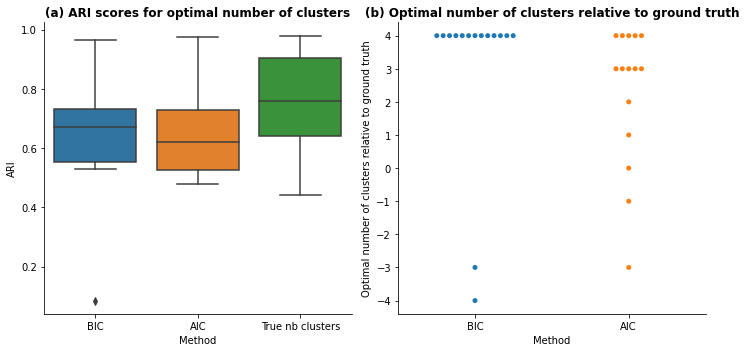

In [67]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(121)
sns.boxplot(data = r1, x = "variable", y = "value")
sns.despine()
plt.ylabel("ARI")
plt.xlabel("Method")
plt.title("(a) ARI scores for optimal number of clusters", fontweight = "bold")

ax = plt.subplot(122)
sns.swarmplot(data = r2, x = "variable", y = "value")
sns.despine()
plt.xlabel("Method")
plt.ylabel("Optimal number of clusters relative to ground truth")
plt.title("(b) Optimal number of clusters relative to ground truth", fontweight = "bold")
plt.tight_layout()
plt.savefig(f"../diagrams/bic.pdf", bbox_inches='tight')

# Run other clustering algorithms

In [3]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")

In [18]:
aris = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
nmis = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
sils = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
cals = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])

def add_scores(Y, pred, embedding, i, t, method="KMeans"):
    score = adjusted_rand_score(Y, pred)
    aris.loc[aris.shape[0]] = [dataset, method, i, score, t]
    score = normalized_mutual_info_score(Y, pred)
    nmis.loc[nmis.shape[0]] = [dataset, method, i, score, t]
    score = silhouette_score(embedding, pred)
    sils.loc[sils.shape[0]] = [dataset, method, i, score, t]
    score = calinski_harabasz_score(embedding, pred)
    cals.loc[cals.shape[0]] = [dataset, method, i, score, t]

In [19]:
for dataset in files:
    print(">>", dataset)
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5","r")
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]

    features = df[df["dataset"] == dataset]["features"].values

    for i in range(len(features)):


        embedding = features[i]
        print(f"Embedding shape {embedding.shape}")
        
        t0 = time.time()
        kmeans = KMeans(n_clusters=cluster_number,
                        init="k-means++",
                        random_state=5)
        pred = kmeans.fit_predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="KMeans")
        
        
        t0 = time.time()
        gmm = mixture.GaussianMixture(n_components=cluster_number)
        gmm.fit(embedding)
        pred = gmm.predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="GMM")
        print(".")
        
        
        embedding = PCA(n_components = 50).fit_transform(embedding)
        print(".", embedding.shape)
        t0 = time.time()
        pred = train.run_leiden(embedding, leiden_n_neighbors=300)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Leiden")

        print(".")
        t0 = time.time()
        ward = AgglomerativeClustering(n_clusters=cluster_number, linkage='ward')
        ward.fit(embedding)
        pred = ward.labels_
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Ward Hierarchical Clust")
        print(".")

        t0 = time.time()
        model = Birch(n_clusters=cluster_number)
        pred = gmm.fit_predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Birch")
        print(".")
        t0 = time.time()
        ms = MeanShift()
        ms.fit(embedding)
        pred = ms.labels_
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Mean Shift")
        print("##")

>> Quake_Smart-seq2_Trachea
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##
>> Quake_Smart-seq2_Diaphragm
Embedding shape (870, 300)
.
. (870, 50)
.
.
.
##
Embedding shape (870, 300)
.
. (870, 50)
.
.
.
##
Embedding shape (870, 300)
.
. (870, 50)
.
.
.
##
>> Quake_10x_Spleen
Embedding shape (9552, 300)
.
. (9552, 50)
.
.
.
##
Embedding shape (9552, 300)
.
. (9552, 50)
.
.
.
##
Embedding shape (9552, 300)
.
. (9552, 50)
.
.
.
##
>> Young
Embedding shape (5685, 300)
.
. (5685, 50)
.
.
.
##
Embedding shape (5685, 300)
.
. (5685, 50)
.
.
.
##
Embedding shape (5685, 300)
.
. (5685, 50)
.
.
.
##
>> mouse_ES_cell
Embedding shape (2717, 300)
.
. (2717, 50)
.
.
.
##
Embedding shape (2717, 300)
.
. (2717, 50)
.
.
.
##
Embedding shape (2717, 300)
.
. (2717, 50)
.
.
.
##
>> Adam
Embedding shape (3660, 300)
.
. (3660, 50)
.
.
.
##
Embedding shape (3660, 300)
.
. (3660, 50)
.
.
.
##
Embedding 

In [5]:
aris.to_pickle(f"../output/pickle_results/{category}/{category}_compare_aris.pkl")

nmis.to_pickle(f"../output/pickle_results/{category}/{category}_compare_nmis.pkl")

sils.to_pickle(f"../output/pickle_results/{category}/{category}_compare_sils.pkl")

cals.to_pickle(f"../output/pickle_results/{category}/{category}_compare_cals.pkl")

NameError: name 'aris' is not defined

In [6]:
aris= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_aris.pkl")

nmis= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_nmis.pkl")

sils= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_sils.pkl")

cals= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_cals.pkl")

In [9]:
nmis.groupby("Method")["time"].mean()

Method
Birch                       0.229181
GMM                         1.258048
KMeans                      0.396875
Leiden                      7.210098
Mean Shift                 14.832126
Ward Hierarchical Clust     0.437024
Name: time, dtype: float64

In [10]:
nmis.groupby("Method")["time"].mean()/0.396875

Method
Birch                       0.577464
GMM                         3.169885
KMeans                      1.000000
Leiden                     18.167177
Mean Shift                 37.372286
Ward Hierarchical Clust     1.101163
Name: time, dtype: float64

In [29]:
datasets = [
    'Quake_Smart-seq2_Trachea',
    'Quake_10x_Bladder',
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Diaphragm',
    'Quake_10x_Limb_Muscle',
    'Quake_Smart-seq2_Limb_Muscle',
    'Romanov',
    'Adam',
    'Muraro',
    'Young',
    'Quake_Smart-seq2_Lung',
    '10X_PBMC',
    'mouse_ES_cell',
    'worm_neuron_cell',
    'mouse_bladder_cell',
]

ordered_datasets = dict(zip(datasets, np.arange(len(datasets))))

In [30]:
aris = aris.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()

aris["ordered_dataset"] = aris["Dataset"].apply(lambda x: ordered_datasets[x])
aris.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_aris.xlsx")

In [31]:
nmis = nmis.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
nmis["ordered_dataset"] = nmis["Dataset"].apply(lambda x: ordered_datasets[x])
nmis.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_nmis.xlsx")

In [32]:
sils = sils.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
sils["ordered_dataset"] = sils["Dataset"].apply(lambda x: ordered_datasets[x])
sils.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_sils.xlsx")

In [33]:
cals = cals.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
cals["ordered_dataset"] = cals["Dataset"].apply(lambda x: ordered_datasets[x])
cals.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_cals.xlsx")

In [34]:
aris.mean().round(2)

Method
KMeans                     0.78
Leiden                     0.52
Birch                      0.75
GMM                        0.71
Mean Shift                 0.45
Ward Hierarchical Clust    0.77
ordered_dataset            7.00
dtype: float64

In [35]:
nmis.mean().round(2)

Method
KMeans                     0.82
Leiden                     0.72
Birch                      0.79
GMM                        0.77
Mean Shift                 0.58
Ward Hierarchical Clust    0.81
ordered_dataset            7.00
dtype: float64

In [36]:
sils.mean().round(2)

Method
KMeans                     0.48
Leiden                     0.32
Birch                      0.47
GMM                        0.43
Mean Shift                 0.43
Ward Hierarchical Clust    0.48
ordered_dataset            7.00
dtype: float64

In [37]:
cals.mean().round(2)

Method
KMeans                     1764.95
Leiden                     1157.58
Birch                      1621.41
GMM                        1518.38
Mean Shift                  244.48
Ward Hierarchical Clust    1746.65
ordered_dataset               7.00
dtype: float64

In [1]:
# !pip install openpyxl